In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import time
import gget
import anndata as an
import scanpy as sc
import scanpy.external as sce
import h5py
import networkx as nx

sc.settings.verbosity = 2
sc.logging.print_header()

scanpy==1.10.4 anndata==0.11.4 umap==0.5.7 numpy==1.26.4 scipy==1.15.2 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.6 pynndescent==0.5.13


# Load in data

In [2]:
path = "/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/anndata/processed_merged_gene_data.h5ad"

adata = sc.read_h5ad(path)
adata

AnnData object with n_obs × n_vars = 16367 × 25126
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'leiden', 'cluster_str', 'S_score', 'G2M_score', 'phase'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_varia

## Marker genes

In [4]:
# Marker genes
def load_pathway(fpath):
    result = []
    with open(fpath) as f:
        for line in f:
            split_line = [x for x in line.strip().split('\t') if x]  # Remove empty strings directly

            row = {'label': split_line[0]}
            for gene in split_line[1:]:
                row[gene] = 1

            result.append(row)

    df = pd.DataFrame(result)
    df = df.fillna(0.0).set_index('label').astype(bool).T  # Chained operations for clarity

    return df

mpath = "/nfs/turbo/umms-indikar/shared/projects/RECODE/marker_genes/PanglaoDB_Augmented_2021.txt"
pang = load_pathway(mpath)

# # Get gene sets
fb_genes = pang[pang['Fibroblasts']].index
myocyte_genes = pang[pang['Myocytes']].index
myoblast_genes = pang[pang['Myoblasts']].index
myofb_genes = pang[pang['Myofibroblasts']].index
ipsc_genes = pang[pang['Pluripotent Stem Cells']].index

print(f"Number of genes for Fibroblasts: {len(fb_genes)}")
print(f"Number of genes for Myocytes: {len(myocyte_genes)}")
print(f"Number of genes for Myoblasts: {len(myoblast_genes)}")
print(f"Number of genes for Myofibroblasts: {len(myofb_genes)}")
print(f"Number of genes for iPSCs: {len(ipsc_genes)}")

Number of genes for Fibroblasts: 232
Number of genes for Myocytes: 163
Number of genes for Myoblasts: 126
Number of genes for Myofibroblasts: 100
Number of genes for iPSCs: 112


In [5]:
### TFs
tfpath = "/home/jrcwycy/iChon2024/New_YvsO/HumanTF_v_1.01.csv"

tf = pd.read_csv(tfpath)

tf = tf[['HGNC symbol', 'Is TF?']]
tf = tf.rename(columns={"HGNC symbol": "gene_name", "Is TF?": "Is_TF"})
tf = tf[tf['Is_TF'] == 'Yes']
tf = tf.drop_duplicates(subset='gene_name')

tf_list = tf['gene_name'].unique()

print(f"N TFs: {tf_list.shape[0]}")

N TFs: 1639


In [7]:
cc_path = "/scratch/indikar_root/indikar1/shared_data/HYB/resources/all_cell_cycle_JC.csv"

cc = pd.read_csv(cc_path)
cc = cc.rename(columns={"Unnamed: 0": "gene_name"})
cc = cc.set_index('gene_name')

is_cols = [col for col in cc.columns if col.startswith('is_')]
cc = cc[is_cols]
print(f"total cc genes: {cc.shape[0]}")

cc_filt = cc.drop(columns='is_liu')
cc_filt = cc_filt[cc_filt.any(axis=1)]
print(f"total genes without Liu: {cc_filt.shape[0]}")

cc_filt = cc_filt.reset_index()
cc_genes = cc_filt['gene_name'].unique()
print(f"Unique cc genes: {len(cc_genes)}")

total cc genes: 4314
total genes without Liu: 250
Unique cc genes: 250


## SCENIC database

In [11]:
def get_regulators(sdf, query, num_results=10, threshold=0):
    """Retrieves the top regulators of a gene or set of genes in a Scenic dataframe.

    Args:
        sdf (pd.DataFrame): The Scenic dataframe.
        query (str or list): The gene(s) of interest to find regulators for.
        num_results (int, optional): The number of top regulators to return. Defaults to 10.

    Returns:
        pd.Index: An index containing the names of the top regulators.
    """
    row = sdf.loc[query]
    filtered = row[row > threshold]
    top_regulators = filtered.sort_values(ascending=False).head(num_results).index.to_list()
    
    return top_regulators
    #return sdf.loc[query].nlargest(num_results).index.to_list()



def get_targets(sdf, query, num_results, threshold=0):
    """Extract the top binding targets of a given transcription factor.

    Args:
        sdf (pd.DataFrame): Scenic database DataFrame.
        query (str): Column name representing the transcription factor.
        num_results (int): Number of top targets to return.
        threshold (int): Threshold for likelihood score

    Returns:
        list: Top binding targets.
    """
    col = sdf[query]
    filtered = col[col > threshold]
    top_targets = filtered.sort_values(ascending=False).head(num_results).index.to_list()
    return top_targets

In [10]:
def load_scenic_database(filepath="/nfs/turbo/umms-indikar/shared/projects/HSC/data/resources/scenic_resources/500bp_up_100bp_down_B.csv"):
    """Loads the Scenic database from a CSV file.

    Args:
        filepath (str, optional): The path to the CSV file. 

    Returns:
        pandas.DataFrame: The Scenic database with 'gene_name' as the index.
    """

    sdf = pd.read_csv(filepath)
    sdf = sdf.rename(columns={"Unnamed: 0": "gene_name"})
    sdf = sdf.set_index("gene_name")
    return sdf


sdf = load_scenic_database()
print(sdf.shape)
sdf.head()

(27015, 1605)


,ABL1,ACAA1,ADNP,ADNP2,AEBP2,AFF4,AHCTF1,AHDC1,AHR,AHRR,...,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSCAN5C,ZSCAN9,ZXDA,ZXDB,ZXDC,ZZZ3
gene_name,,,,,,,,,,,,,,,,,,,,,
A1BG,1.65,0.0,5.060,0.0,0.0,8.470,6.400,2.290,0.83060,0.0,...,0.0,0.0,0.0,0.0,1.32,1.448,1.790,1.484333,0.0,1.37
A1BG-AS1,0.00,0.0,0.545,0.0,0.0,0.379,0.000,0.000,0.14640,0.0,...,0.0,0.0,0.0,0.0,0.00,0.770,1.465,1.032333,0.0,0.00
A1CF,1.55,0.0,0.000,0.0,0.0,3.780,4.880,1.092,0.31400,0.0,...,0.0,0.0,0.0,0.0,0.00,0.920,2.865,1.910000,0.0,2.67
A2M,1.39,0.0,0.827,0.0,0.0,4.700,0.810,1.055,0.27314,0.0,...,0.0,0.0,0.0,0.0,0.00,0.535,0.885,0.698000,0.0,3.45
A2M-AS1,0.00,0.0,0.000,0.0,0.0,1.450,0.111,0.000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.00,0.800,0.000,0.059333,0.0,0.00


# Get DE genes

In [3]:
sc.tl.rank_genes_groups(
    adata, 
    groupby="pooled_condition",
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    use_raw=False,
    layer='log_norm',
    pts=True,
    key_added='condition_all',
)

sc.tl.rank_genes_groups(
    adata, 
    groupby="pooled_condition",
    reference='Control',
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    use_raw=False,
    layer='log_norm',
    pts=True,
    key_added='condition_vs_control',
)

ranking genes
    finished (0:01:11)
ranking genes
    finished (0:02:05)


In [15]:
### Filter for significance

deg_key = 'condition_vs_control'
# deg_key = 'condition_all'

deg = sc.get.rank_genes_groups_df(
    adata, 
    group=None,
    key=deg_key,
)

print(deg.shape)


pval_cutoff = 0.01       
logfc_cutoff = 1.0       
print(f"Using p-value cutoff: {pval_cutoff} and log fold change cutoff: {logfc_cutoff}")

sig = deg.copy()

sig['abs_lfc'] = sig['logfoldchanges'].apply('abs')

sig = sig[(sig['abs_lfc'] > logfc_cutoff) & (sig['pvals_adj'] < pval_cutoff)]
print(f"N unique significant DEGs: {sig['names'].nunique()}")
sig.head()

(75378, 7)
Using p-value cutoff: 0.01 and log fold change cutoff: 1.0
N unique significant DEGs: 5312


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,abs_lfc
0,mmMYOD1,MT-ND4,71.247650,2.768783,0.0,0.0,0.999113,2.768783
1,mmMYOD1,MYOD1,66.925995,31.986927,0.0,0.0,0.936170,31.986927
2,mmMYOD1,LINC-PINT,60.860970,2.704369,0.0,0.0,0.971631,2.704369
3,mmMYOD1,NAV3,59.871517,3.427659,0.0,0.0,0.922429,3.427659
4,mmMYOD1,TAF1D,55.939564,2.645126,0.0,0.0,0.956560,2.645126


In [50]:
# check for overlap between MYOD1/PRRX1 target genes

myod_targets = get_targets(sdf, 'MYOD1', 200)
prrx_targets = get_targets(sdf, 'PRRX1', 200)

overlap_targets = [gene for gene in myod_targets if gene in prrx_targets]
print(f"N genes that are targets for both MYOD1 and PRRX1: {len(overlap_targets)}")

N genes that are targets for both MYOD1 and PRRX1: 21


In [38]:
conditions = sig['group'].unique().tolist()
genes_of_interest = ['MYOD1', 'PRRX1']
n_targets = 200
res = {}

for group in conditions:
    print(f"\n--------- {group} vs Control ---------")
    tmp = sig[sig['group'] == group]
    print(f"N DE genes: {tmp['names'].nunique()}\n")
    de_genes = tmp['names'].unique()
    
    res[group] = {}
    
    for gene in genes_of_interest:
        targets = get_targets(sdf, gene, n_targets)
        print(f"Using top {len(targets)} {gene} target genes...")
        
        de_targets = [g for g in de_genes if g in targets]
        print(f"DE {gene} target genes: {len(de_targets)}\n")
        
        res[group][gene] = de_targets


--------- mmMYOD1 vs Control ---------
N DE genes: 4405

Using top 200 MYOD1 target genes...
DE MYOD1 target genes: 35

Using top 200 PRRX1 target genes...
DE PRRX1 target genes: 33


--------- siPRRX1 vs Control ---------
N DE genes: 2530

Using top 200 MYOD1 target genes...
DE MYOD1 target genes: 23

Using top 200 PRRX1 target genes...
DE PRRX1 target genes: 17


--------- siPRRX1/mmMYOD1 vs Control ---------
N DE genes: 3416

Using top 200 MYOD1 target genes...
DE MYOD1 target genes: 32

Using top 200 PRRX1 target genes...
DE PRRX1 target genes: 28



In [53]:
# check for overlap between MYOD1/PRRX1 target genes

n_targets = 200

myod_targets = get_targets(sdf, 'MYOD1', n_targets)
prrx_targets = get_targets(sdf, 'PRRX1', n_targets)

overlap_targets = [gene for gene in myod_targets if gene in prrx_targets]
print(f"N genes that are targets for both MYOD1 and PRRX1: {len(overlap_targets)}")


sig_both = sig['names'].isin(overlap_targets)
sig_myod = sig['names'].isin(myod_targets)
sig_prrx = sig['names'].isin(prrx_targets)

conditions = [sig_both, sig_myod, sig_prrx]
choices = ['Both', 'MYOD1', 'PRRX1']

sig['target_of'] = np.select(conditions, choices, default=np.nan)

sig.head()

N genes that are targets for both MYOD1 and PRRX1: 21


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,abs_lfc,target_of
0,mmMYOD1,MT-ND4,71.247650,2.768783,0.0,0.0,0.999113,2.768783,nan
1,mmMYOD1,MYOD1,66.925995,31.986927,0.0,0.0,0.936170,31.986927,nan
2,mmMYOD1,LINC-PINT,60.860970,2.704369,0.0,0.0,0.971631,2.704369,nan
3,mmMYOD1,NAV3,59.871517,3.427659,0.0,0.0,0.922429,3.427659,nan
4,mmMYOD1,TAF1D,55.939564,2.645126,0.0,0.0,0.956560,2.645126,nan


In [56]:
sig[sig['target_of'] == 'Both']

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,abs_lfc,target_of
391,mmMYOD1,RABGAP1L,22.541050,1.336130,1.643719e-112,4.677246e-111,0.592199,1.336130,Both
482,mmMYOD1,KCNMA1,20.762136,1.335102,9.523794e-96,2.296496e-94,0.591755,1.335102,Both
751,mmMYOD1,LCOR,17.253014,1.384432,1.062107e-66,1.821605e-65,0.456560,1.384432,Both
3322,mmMYOD1,EPHB2,6.159883,2.035365,7.279880e-10,3.475475e-09,0.125000,2.035365,Both
25218,siPRRX1,KCNMA1,36.833286,1.559335,5.415625e-297,6.157149e-295,0.731364,1.559335,Both
25493,siPRRX1,RABGAP1L,24.312365,1.052706,1.450735e-130,5.731315e-129,0.618596,1.052706,Both
25807,siPRRX1,LCOR,19.361767,1.089129,1.622265e-83,3.845380e-82,0.478449,1.089129,Both
29259,siPRRX1,EPHB2,5.639383,1.493829,1.706605e-08,7.955501e-08,0.106804,1.493829,Both
50562,siPRRX1/mmMYOD1,RABGAP1L,25.165634,1.200671,9.530287e-140,3.639179e-138,0.613518,1.200671,Both
50612,siPRRX1/mmMYOD1,KCNMA1,23.889410,1.201792,3.946345e-126,1.341757e-124,0.619295,1.201792,Both


In [ ]:
# res['mmMYOD1']['MYOD1'] 

(24, 10)


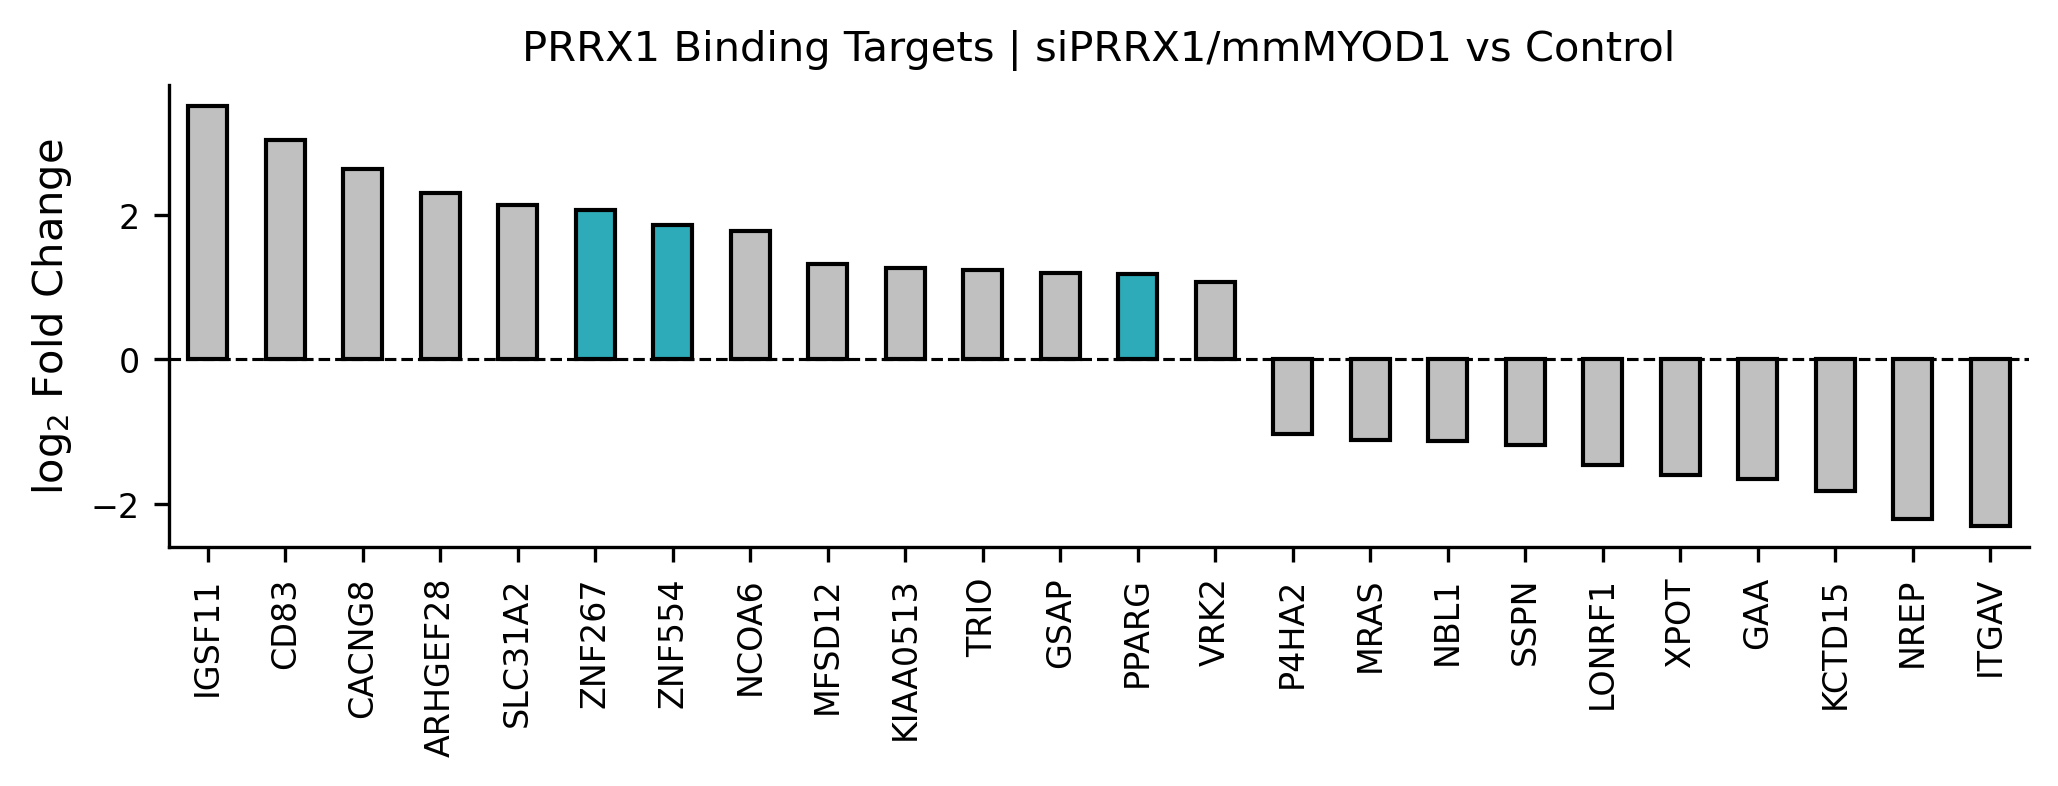

In [60]:
# Plot DE binding targets
query = 'PRRX1'
condition = 'siPRRX1/mmMYOD1'

# n_targets = 200

# targets = get_targets(sdf, query, n_targets)

tmp = sig[sig['group'] == condition]
# de_genes = tmp['names'].unique()

# overlap = []

# for gene in de_genes:
#     if gene in targets:
#         overlap.append(gene)
        
# print(f"DE genes that are {query} binding targets: {len(overlap)}")

# filter sig_filt df for myod1 targets
# sig_targets = tmp[tmp['names'].isin(targets)]

sig_targets = tmp[tmp['target_of'] == query]

sig_targets = sig_targets.sort_values(by='logfoldchanges', ascending=False)

sig_targets['is_tf'] = sig_targets['names'].isin(tf_list)

# filter for just upregulated genes
#  sig_targets = sig_targets[sig_targets['logfoldchanges'] > 0]

print(sig_targets.shape)
sig_targets.head()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 2

colors = ["silver", "tab:cyan"]

sns.barplot(
    data=sig_targets,
    x='names',
    y='logfoldchanges',
    hue='is_tf',
    palette=colors,
    width=0.5,
    ec='k', 
    zorder=1,
    legend=False,
)

plt.axhline(y=0, color='k', linestyle='--', lw=0.75, zorder=0)

plt.ylabel("log$_2$ Fold Change")
plt.xlabel("")

plt.yticks(fontsize=8)
plt.xticks(fontsize=8, rotation=90)

plt.title(f"{query} Binding Targets | {condition} vs Control", fontsize=10)

sns.despine()
plt.show()

In [40]:
# Identify DE target genes of MYOD1 and PRRX1

In [ ]:
# Identify DE TFs and if their target genes are also DE?